# Optimize classifier on best dataset from `prefiltering.ipynb`

TODO: downweight KNRGL in evaluation?

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from flaml import AutoML
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

In [3]:
df = pd.read_parquet("CommonBrain_prefiltered.pqt")
features = np.loadtxt("CommonBrain_prefiltered_features.txt", dtype=str)

In [8]:
df.shape

(1657410, 59)

In [5]:
# filter the data based on dictionary of boolean filters
print("filtering data...")
min_r1_5 = (df["r1_fwd"] >= 5) | (df["r1_rev"] >= 5)
high_ya_low_yg = (df["YA_mean"] > 20) & (df["YG_mean"] < 10)
clf_df = df.loc[(min_r1_5) & (high_ya_low_yg)].reset_index(drop=True)
clf_df.loc[clf_df["label"] == "RMSK", "label"] = "OTHER"
clf_df.loc[clf_df["label"] == "FLANK", "label"] = "OTHER"

assert clf_df["label"].nunique() == 2, "only two labels should be present"

print("label counts: ")
print(clf_df["label"].value_counts())

# encode labels
print("encoding labels as integers...")
clf_df["label_encoded"] = clf_df["label"].map({"KNRGL": 1, "OTHER": 0})

# split into train and test sets
print("splitting data into train and test sets...")
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=1)  # take first fold
sgkf = sgkf.split(clf_df[features], clf_df["label_encoded"], groups=clf_df["cell_id"])
train_inds, test_inds = next(sgkf)
train = clf_df.iloc[train_inds]
test = clf_df.iloc[test_inds]

filtering data...
label counts: 
OTHER    1618685
KNRGL      38725
Name: label, dtype: int64
encoding labels as integers...
splitting data into train and test sets...


## Test different sample weights

In [ ]:
# test various sample weights

# set up the model
clf = RandomForestClassifier(n_estimators=50, oob_score=True, n_jobs=10, random_state=1)

# setup folds for grid search
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=1)
sgkf = sgkf.split(train[features], train["label_encoded"], groups=train["cell_id"])

# setup params
params = {
    "class_weight": [
        None,
        "balanced",
        "balanced_subsample",
        {0: 10, 1: 1},
        {0: 100, 1: 11},
        {0: 1, 1: 10},
        {0: 1, 1: 100},
    ],
}

# run grid search
searcher = GridSearchCV(clf, param_grid=params, scoring="f1", cv=sgkf, n_jobs=2)
searcher = searcher.fit(train[features], train["label_encoded"])

# print results
pd.DataFrame(searcher.cv_results_)

## Optimize a xgboost classifier using `AutoML`

[flaml.automl.automl: 04-04 17:26:59] {2726} INFO - task = classification
[flaml.automl.automl: 04-04 17:26:59] {2728} INFO - Data split method: group
[flaml.automl.automl: 04-04 17:26:59] {2731} INFO - Evaluation method: holdout
[flaml.automl.automl: 04-04 17:26:59] {2858} INFO - Minimizing error metric: 1-f1
[flaml.automl.automl: 04-04 17:26:59] {3004} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.automl: 04-04 17:26:59] {3334} INFO - iteration 0, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:26:59] {3472} INFO - Estimated sufficient time budget=573309s. Estimated necessary time budget=573s.
[flaml.automl.automl: 04-04 17:26:59] {3519} INFO -  at 18.5s,	estimator xgboost's best error=0.8267,	best estimator xgboost's best error=0.8267
[flaml.automl.automl: 04-04 17:26:59] {3334} INFO - iteration 1, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:26:59] {3519} INFO -  at 18.8s,	estimator xgboost's best error=0.8267,	best estimator xgboost's best error=0.8267
[flaml.automl.automl: 04-04 17:26:59] {3334} INFO - iteration 2, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:00] {3519} INFO -  at 19.0s,	estimator xgboost's best error=0.8267,	best estimator xgboost's best error=0.8267
[flaml.automl.automl: 04-04 17:27:00] {3334} INFO - iteration 3, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:00] {3519} INFO -  at 19.3s,	estimator xgboost's best error=0.8267,	best estimator xgboost's best error=0.8267
[flaml.automl.automl: 04-04 17:27:00] {3334} INFO - iteration 4, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:00] {3519} INFO -  at 19.5s,	estimator xgboost's best error=0.6681,	best estimator xgboost's best error=0.6681
[flaml.automl.automl: 04-04 17:27:00] {3334} INFO - iteration 5, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:00] {3519} INFO -  at 19.8s,	estimator xgboost's best error=0.6681,	best estimator xgboost's best error=0.6681
[flaml.automl.automl: 04-04 17:27:00] {3334} INFO - iteration 6, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:01] {3519} INFO -  at 20.0s,	estimator xgboost's best error=0.6574,	best estimator xgboost's best error=0.6574
[flaml.automl.automl: 04-04 17:27:01] {3334} INFO - iteration 7, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:01] {3519} INFO -  at 20.3s,	estimator xgboost's best error=0.6252,	best estimator xgboost's best error=0.6252
[flaml.automl.automl: 04-04 17:27:01] {3334} INFO - iteration 8, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:01] {3519} INFO -  at 20.6s,	estimator xgboost's best error=0.6252,	best estimator xgboost's best error=0.6252
[flaml.automl.automl: 04-04 17:27:01] {3334} INFO - iteration 9, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:01] {3519} INFO -  at 21.0s,	estimator xgboost's best error=0.5776,	best estimator xgboost's best error=0.5776
[flaml.automl.automl: 04-04 17:27:01] {3334} INFO - iteration 10, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:02] {3519} INFO -  at 21.3s,	estimator xgboost's best error=0.5776,	best estimator xgboost's best error=0.5776
[flaml.automl.automl: 04-04 17:27:02] {3334} INFO - iteration 11, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:02] {3519} INFO -  at 21.5s,	estimator xgboost's best error=0.5776,	best estimator xgboost's best error=0.5776
[flaml.automl.automl: 04-04 17:27:02] {3334} INFO - iteration 12, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:02] {3519} INFO -  at 21.8s,	estimator xgboost's best error=0.5776,	best estimator xgboost's best error=0.5776
[flaml.automl.automl: 04-04 17:27:02] {3334} INFO - iteration 13, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:03] {3519} INFO -  at 22.1s,	estimator xgboost's best error=0.5656,	best estimator xgboost's best error=0.5656
[flaml.automl.automl: 04-04 17:27:03] {3334} INFO - iteration 14, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:03] {3519} INFO -  at 22.4s,	estimator xgboost's best error=0.5656,	best estimator xgboost's best error=0.5656
[flaml.automl.automl: 04-04 17:27:03] {3334} INFO - iteration 15, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:03] {3519} INFO -  at 22.7s,	estimator xgboost's best error=0.5656,	best estimator xgboost's best error=0.5656
[flaml.automl.automl: 04-04 17:27:03] {3334} INFO - iteration 16, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:03] {3519} INFO -  at 23.0s,	estimator xgboost's best error=0.5508,	best estimator xgboost's best error=0.5508
[flaml.automl.automl: 04-04 17:27:03] {3334} INFO - iteration 17, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:04] {3519} INFO -  at 23.3s,	estimator xgboost's best error=0.5508,	best estimator xgboost's best error=0.5508
[flaml.automl.automl: 04-04 17:27:04] {3334} INFO - iteration 18, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:04] {3519} INFO -  at 23.6s,	estimator xgboost's best error=0.5508,	best estimator xgboost's best error=0.5508
[flaml.automl.automl: 04-04 17:27:04] {3334} INFO - iteration 19, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:04] {3519} INFO -  at 23.8s,	estimator xgboost's best error=0.5508,	best estimator xgboost's best error=0.5508
[flaml.automl.automl: 04-04 17:27:04] {3334} INFO - iteration 20, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:05] {3519} INFO -  at 24.1s,	estimator xgboost's best error=0.5508,	best estimator xgboost's best error=0.5508
[flaml.automl.automl: 04-04 17:27:05] {3334} INFO - iteration 21, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:05] {3519} INFO -  at 24.4s,	estimator xgboost's best error=0.5508,	best estimator xgboost's best error=0.5508
[flaml.automl.automl: 04-04 17:27:05] {3334} INFO - iteration 22, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:05] {3519} INFO -  at 24.7s,	estimator xgboost's best error=0.4663,	best estimator xgboost's best error=0.4663
[flaml.automl.automl: 04-04 17:27:05] {3334} INFO - iteration 23, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:06] {3519} INFO -  at 25.0s,	estimator xgboost's best error=0.4663,	best estimator xgboost's best error=0.4663
[flaml.automl.automl: 04-04 17:27:06] {3334} INFO - iteration 24, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:06] {3519} INFO -  at 25.4s,	estimator xgboost's best error=0.4471,	best estimator xgboost's best error=0.4471
[flaml.automl.automl: 04-04 17:27:06] {3334} INFO - iteration 25, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:06] {3519} INFO -  at 25.7s,	estimator xgboost's best error=0.4471,	best estimator xgboost's best error=0.4471
[flaml.automl.automl: 04-04 17:27:06] {3334} INFO - iteration 26, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:07] {3519} INFO -  at 26.3s,	estimator xgboost's best error=0.4471,	best estimator xgboost's best error=0.4471
[flaml.automl.automl: 04-04 17:27:07] {3334} INFO - iteration 27, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:07] {3519} INFO -  at 26.7s,	estimator xgboost's best error=0.4471,	best estimator xgboost's best error=0.4471
[flaml.automl.automl: 04-04 17:27:07] {3334} INFO - iteration 28, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:08] {3519} INFO -  at 27.1s,	estimator xgboost's best error=0.4349,	best estimator xgboost's best error=0.4349
[flaml.automl.automl: 04-04 17:27:08] {3334} INFO - iteration 29, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:08] {3519} INFO -  at 27.4s,	estimator xgboost's best error=0.4349,	best estimator xgboost's best error=0.4349
[flaml.automl.automl: 04-04 17:27:08] {3334} INFO - iteration 30, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:09] {3519} INFO -  at 28.2s,	estimator xgboost's best error=0.4104,	best estimator xgboost's best error=0.4104
[flaml.automl.automl: 04-04 17:27:09] {3334} INFO - iteration 31, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:09] {3519} INFO -  at 28.9s,	estimator xgboost's best error=0.4075,	best estimator xgboost's best error=0.4075
[flaml.automl.automl: 04-04 17:27:09] {3334} INFO - iteration 32, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:10] {3519} INFO -  at 29.6s,	estimator xgboost's best error=0.4075,	best estimator xgboost's best error=0.4075
[flaml.automl.automl: 04-04 17:27:10] {3334} INFO - iteration 33, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:11] {3519} INFO -  at 30.3s,	estimator xgboost's best error=0.4075,	best estimator xgboost's best error=0.4075
[flaml.automl.automl: 04-04 17:27:11] {3334} INFO - iteration 34, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:11] {3519} INFO -  at 30.9s,	estimator xgboost's best error=0.4075,	best estimator xgboost's best error=0.4075
[flaml.automl.automl: 04-04 17:27:11] {3334} INFO - iteration 35, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:12] {3519} INFO -  at 31.5s,	estimator xgboost's best error=0.4075,	best estimator xgboost's best error=0.4075
[flaml.automl.automl: 04-04 17:27:12] {3334} INFO - iteration 36, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:12] {3519} INFO -  at 32.0s,	estimator xgboost's best error=0.4075,	best estimator xgboost's best error=0.4075
[flaml.automl.automl: 04-04 17:27:12] {3334} INFO - iteration 37, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:14] {3519} INFO -  at 33.9s,	estimator xgboost's best error=0.2590,	best estimator xgboost's best error=0.2590
[flaml.automl.automl: 04-04 17:27:14] {3334} INFO - iteration 38, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:16] {3519} INFO -  at 35.4s,	estimator xgboost's best error=0.2590,	best estimator xgboost's best error=0.2590
[flaml.automl.automl: 04-04 17:27:16] {3334} INFO - iteration 39, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:18] {3519} INFO -  at 37.1s,	estimator xgboost's best error=0.2590,	best estimator xgboost's best error=0.2590
[flaml.automl.automl: 04-04 17:27:18] {3334} INFO - iteration 40, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:19] {3519} INFO -  at 38.5s,	estimator xgboost's best error=0.2590,	best estimator xgboost's best error=0.2590
[flaml.automl.automl: 04-04 17:27:19] {3334} INFO - iteration 41, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:20] {3519} INFO -  at 39.7s,	estimator xgboost's best error=0.2590,	best estimator xgboost's best error=0.2590
[flaml.automl.automl: 04-04 17:27:20] {3334} INFO - iteration 42, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:21] {3519} INFO -  at 40.8s,	estimator xgboost's best error=0.2590,	best estimator xgboost's best error=0.2590
[flaml.automl.automl: 04-04 17:27:21] {3334} INFO - iteration 43, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:23] {3519} INFO -  at 42.0s,	estimator xgboost's best error=0.2590,	best estimator xgboost's best error=0.2590
[flaml.automl.automl: 04-04 17:27:23] {3334} INFO - iteration 44, current learner xgboost


/raidixshare_log-g/mcuoco/conda/envs/shell/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.automl: 04-04 17:27:35] {3519} INFO -  at 54.7s,	estimator xgboost's best error=0.1387,	best estimator xgboost's best error=0.1387
[flaml.automl.automl: 04-04 17:27:35] {3635} INFO - selected model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.8679735144738119, colsample_bynode=None,
              colsample_bytree=0.7751815494318067, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3717662125523864, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=238,
              min_child_weight=4.307689578212624, missing=nan,
              monotone_constraints=None, n_estimators=174, n_jobs=10,
              num_parallel_tree=None, predict

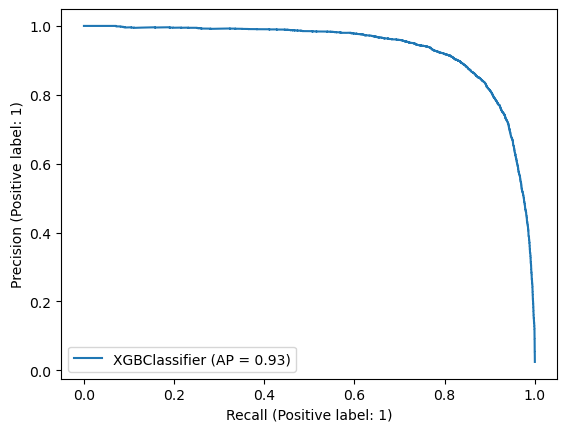

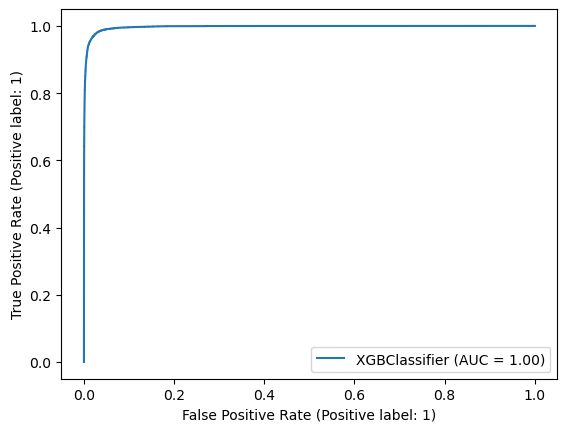

In [6]:
automl = AutoML()
automl.fit(
    X_train=train[features],
    y_train=train["label_encoded"],
    X_val=test[features],
    y_val=test["label_encoded"],
    task="classification",
    metric="f1",
    n_jobs=10,
    n_splits=3,
    estimator_list=["xgboost"],
    groups=train["cell_id"],
    groups_val=test["cell_id"],
    early_stop=True,
    time_budget=60,
)
PrecisionRecallDisplay.from_estimator(
    automl.model.estimator, test[features], test["label_encoded"]
)
RocCurveDisplay.from_estimator(
    automl.model.estimator, test[features], test["label_encoded"]
)